In [1]:
import numpy as np
import pandas as pd
from os.path import join
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

In [10]:
RECORDING_DIR = "recordings"
OUTPUT_DIR = "output_wav"
MECH_READINGS_FILE = "mechanical_sensor.csv"
SOUND_READINGS_FILE = "sound_sensor.csv"

In [11]:
mech_cols = ["date", "time", "x1", "x2"]
sound_cols = ["date", "time", "sound", "loudness"]
col_names = ["raw_audio", "filtered_audio"]

In [17]:
mech_file_path = join(RECORDING_DIR, MECH_READINGS_FILE)
mech_data = pd.read_csv(mech_file_path, names=mech_cols)

In [18]:
mech_data.head(2)

,date,time,x1,x2
0,2023-10-3,22:37,0,0.00 mm
1,2023-10-3,22:38,0,0.00 mm


In [6]:
def normalize_signal(x):
    x /= np.max(np.abs(x),axis=0)
    x -= 0.5
    return x

In [7]:
# Fs = 115200
Fs = 9600
raw_audio = normalize_signal(raw_audio)
filtered_audio = normalize_signal(filtered_audio)
N = len(raw_audio)
time = np.linspace(0, N/Fs, N)

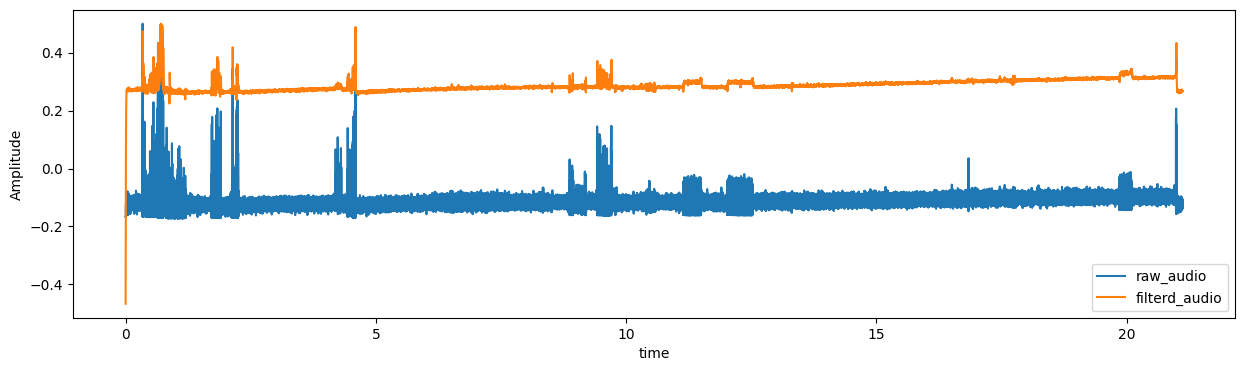

In [8]:
plt.figure(figsize=(15,4))
plt.plot(time, raw_audio, label="raw_audio")
plt.plot(time, filtered_audio, label="filterd_audio")
plt.xlabel("time")
plt.ylabel("Amplitude")
plt.legend()

In [9]:
wav_file_path = join(OUTPUT_DIR, "test_raw.wav")
write(wav_file_path, Fs, raw_audio)